# 1 Import Packages

In [1]:
import xarray as xr
import os
import numpy as np

In [2]:
import src.config as config
import src.utils as utils

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 2 Metadata

In [4]:
experiment_family = "GrandEnsemble"
experiment = "hist"
realization = "lkm0001"
processing = "mergetime_rho_remap_masked_ym"

filename_dict = dict(experiment_family = experiment_family,
experiment = experiment,
realization = realization)

In [10]:
train_realization_id_list = np.arange(1, 80+1)
valid_realization_id_list = np.arange(81, 90+1)

In [11]:
train_realization_list = ["lkm{}".format(str(realization_id).zfill(4)) for realization_id in train_realization_id_list]
valid_realization_list = ["lkm{}".format(str(realization_id).zfill(4)) for realization_id in valid_realization_id_list]

In [12]:
def load_realization_list(realization_list, filename_dict):
    file_list = []
    data_list = []
    for realization in realization_list:
        filename_dict["realization"] = realization
        filename_dict["processing"] = "mergetime_rho_remap_masked_ym"

        path, filename = utils.gen_absolute_path_and_filename(
        filename_dict = filename_dict,
        init_path = config.data_pro_path, 
        init_filestem ="", 
        filetype="nc" 
        )

        file = os.path.join(path, filename)
        assert os.path.exists(file), "file {} does not exist".format(file)
        data = xr.open_dataset(file)["rho"].assign_coords({"realization": realization})
        data_list.append(data)
        
    return xr.concat(data_list, dim="realization")

In [13]:
def load_amoc_realization_list(realization_list, filename_dict):
    file_list = []
    data_list = []
    for realization in realization_list:
        filename_dict["realization"] = realization
        filename_dict["processing"] = "amoc_ym"
        path, filename = utils.gen_absolute_path_and_filename(
        filename_dict = filename_dict,
        init_path = config.data_pro_path, 
        init_filestem ="", 
        filetype="nc" 
        )

        file = os.path.join(path, filename)
        assert os.path.exists(file), "file {} does not exist".format(file)
        data = xr.open_dataset(file)["atlantic_moc"].assign_coords({"realization": realization})
        data_list.append(data)
        
    return xr.concat(data_list, dim="realization")

# 3 Processing

## 3.1 Load Data

In [14]:
train_data = load_realization_list(train_realization_list, filename_dict)
valid_data = load_realization_list(valid_realization_list, filename_dict)

train_data_amoc = load_amoc_realization_list(train_realization_list, filename_dict)
valid_data_amoc = load_amoc_realization_list(valid_realization_list, filename_dict)

In [15]:
lev = train_data.lev
lon = train_data.lon
lat = train_data.lat

## 3.2 Feature scaling

### 3.2.1 Stack Data

In [16]:
def convert_time_to_year(data):
    
    time = data.time
    year = time.dt.year
    
    return data.assign_coords({"year":year}).swap_dims({"time":"year"})
    
    

In [17]:
train_data_stack = convert_time_to_year(train_data).stack(sample= ("realization","year"))
valid_data_stack = convert_time_to_year(valid_data).stack(sample= ("realization","year"))

### 3.2.2 Select Latitude

In [21]:
train_data_stack_26N = train_data_stack.sel(lat=26, method="nearest")
valid_data_stack_26N = valid_data_stack.sel(lat=26, method="nearest")

### 3.2.3 Mask zero values

In [22]:
train_data_stack_26N_masked = train_data_stack_26N.where(train_data_stack_26N!=0)
valid_data_stack_26N_masked = valid_data_stack_26N.where(valid_data_stack_26N!=0)

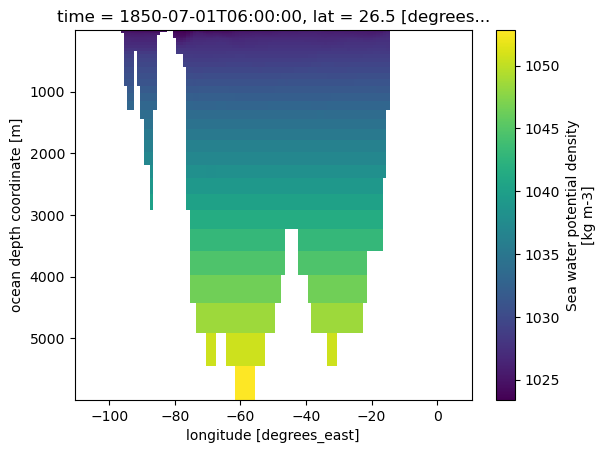

In [23]:
train_data_stack_26N_masked.isel(sample=0).plot.pcolormesh()
plt.gca().invert_yaxis()


### 3.2.4 Subtract Zonal Climatology

In [43]:
train_data_stack_26N_masked_mean = train_data_stack_26N_masked.mean(dim=("lon","sample"))
train_data_stack_26N_masked_std = train_data_stack_26N_masked.std(dim=("lon","sample"))

In [48]:
train_data_stack_26N_masked_zonanom.std(dim="sample").plot.pcolormesh(vmin=0, vmax=1, cmap="Reds")
plt.gca().invert_yaxis()


In [24]:
train_data_stack_26N_masked_zonanom =  train_data_stack_26N_masked - train_data_stack_26N_masked.mean(dim=("lon","sample"))
train_data_stack_26N_masked_zonanom =  train_data_stack_26N_masked - train_data_stack_26N_masked.mean(dim=("lon","sample"))

(1000.0, 0.0)

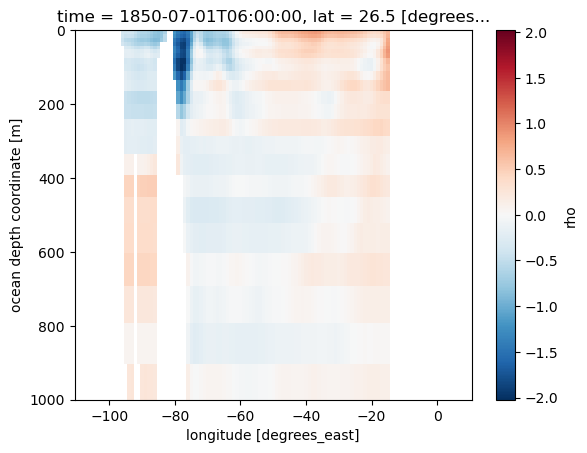

In [25]:
train_data_stack_26N_masked_zonanom.isel(sample=0).plot.pcolormesh()
plt.gca().invert_yaxis()
plt.ylim(1000,0)

### 3.2.5 Save

In [41]:
output_dir = os.path.join(config.data_pro_path, "ml_transform")
os.makedirs(output_dir, exist_ok = True)

In [76]:
train_data_stack_lonlatstandardized.unstack().to_netcdf(os.path.join(output_dir,"train_data_stack_lonlatstandardized.nc" ))
valid_data_stack_lonlatstandardized.unstack().to_netcdf(os.path.join(output_dir,"valid_data_stack_lonlatstandardized.nc" ))

## 3.3 Process Output

### 3.3.1 Select Depth and Lat

In [26]:
amoc_depth = 1020
amoc_lat = 26.5

In [27]:
train_data_amoc_depth_1020_lat_26 = convert_time_to_year(train_data_amoc.sel(depth_2 = amoc_depth, lat= amoc_lat).isel(lon=0)/(1025*10**6))
valid_data_amoc_depth_1020_lat_26 = convert_time_to_year(valid_data_amoc.sel(depth_2 = amoc_depth, lat= amoc_lat).isel(lon=0)/(1025*10**6))

### 3.3.2 Calculate Moments

In [28]:
train_data_amoc_depth_1020_lat_26_samplemean = train_data_amoc_depth_1020_lat_26.mean()
train_data_amoc_depth_1020_lat_26_samplestd = train_data_amoc_depth_1020_lat_26.std()

### 3.3.3 Standardize

In [29]:
train_data_amoc_depth_1020_lat_26_samplestandardized = (train_data_amoc_depth_1020_lat_26 - train_data_amoc_depth_1020_lat_26_samplemean)/train_data_amoc_depth_1020_lat_26_samplestd
valid_data_amoc_depth_1020_lat_26_samplestandardized = (valid_data_amoc_depth_1020_lat_26 - train_data_amoc_depth_1020_lat_26_samplemean)/train_data_amoc_depth_1020_lat_26_samplestd

# 4 Calculate Correlations

In [31]:
corr = xr.corr( train_data_stack_26N_masked_zonanom.unstack(),train_data_amoc_depth_1020_lat_26_samplestandardized, dim=("realization","year"))

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(1000.0, 0.0)

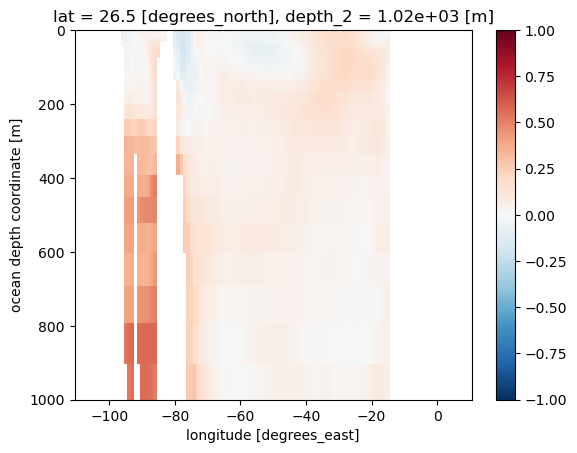

In [37]:

corr.plot.pcolormesh(vmin=-1, vmax=1, cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.ylim(1000,0)

In [83]:
train_data_amoc_depth_1020_lat_26_samplestandardized.drop_vars(("lat","lon","depth_2"))

<xarray.DataArray 'atlantic_moc' (realization: 50, time: 156)>
array([[ 0.14572464,  1.54529223,  1.04383349, ..., -1.13968417,
        -1.81354121, -1.15162024],
       [-1.4148815 , -1.10220106,  0.90139767, ..., -0.32141923,
         0.17460652, -0.26987789],
       [ 1.66555936,  1.57801022, -0.99144016, ...,  0.31777325,
        -1.05605069, -0.78821491],
       ...,
       [-0.6830836 ,  0.45695078, -0.1966061 , ..., -0.63589765,
        -0.3268162 , -0.19112959],
       [-0.41704731, -1.03287945,  0.40633995, ..., -0.28400366,
        -1.16479298, -0.79567851],
       [ 0.41187499,  0.23445493, -1.28768205, ...,  0.30115311,
         0.32619588,  0.28651706]])
Coordinates:
  * time         (time) datetime64[ns] 1850-07-16T11:15:00 ... 2005-07-16T11:...
  * realization  (realization) <U7 'lkm0001' 'lkm0002' ... 'lkm0049' 'lkm0050'

In [85]:
train_data_stack_26N_masked_zonanom.unstack().isel(lev=0, lon=20)

<xarray.DataArray 'rho' (realization: 50, time: 156)>
array([[-0.6986084 , -0.72766113, -0.6921387 , ..., -0.6594238 ,
        -0.69091797, -0.7036133 ],
       [-0.5687256 , -0.8607178 , -0.38391113, ..., -0.46533203,
        -0.42907715, -0.46289062],
       [-0.37268066, -0.62841797, -0.6287842 , ..., -0.5727539 ,
        -0.6303711 , -0.5859375 ],
       ...,
       [-0.37805176, -0.42907715, -0.34985352, ..., -0.7799072 ,
        -0.7203369 , -0.73010254],
       [-0.7883301 , -0.6298828 , -0.6838379 , ..., -0.4951172 ,
        -0.44506836, -0.57263184],
       [-0.5769043 , -0.7393799 , -0.8765869 , ..., -0.619751  ,
        -0.5780029 , -0.654541  ]], dtype=float32)
Coordinates:
  * realization  (realization) <U7 'lkm0001' 'lkm0002' ... 'lkm0049' 'lkm0050'
  * time         (time) datetime64[ns] 1850-07-01T06:00:00 ... 2005-07-01T06:...
    lon          float64 -90.0
    lat          float64 26.5
    lev          float64 6.0

In [84]:
xr.corr(train_data_stack_26N_masked_zonanom.unstack().isel(lev=0, lon=20),train_data_amoc_depth_1020_lat_26_samplestandardized.drop_vars(("lat","lon","depth_2")))

<xarray.DataArray ()>
array(nan)
Coordinates:
    lon      float64 -90.0
    lat      float64 26.5
    lev      float64 6.0

(1000.0, 0.0)

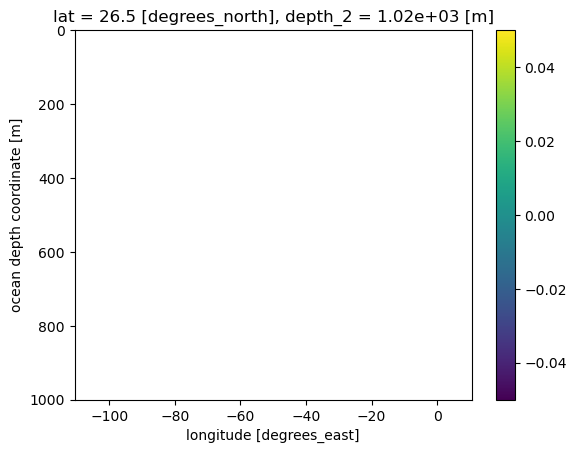

In [54]:
corr.plot.pcolormesh()
plt.gca().invert_yaxis()
plt.ylim(1000,0)

In [45]:
train_data_amoc_depth_1020_lat_26_samplemean.to_netcdf(os.path.join(output_dir,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))
train_data_amoc_depth_1020_lat_26_samplestd.to_netcdf( os.path.join(output_dir, "train_data_amoc_depth_1020_lat_26_samplestd.nc"))

NameError: name 'output_dir' is not defined

### 3.3.4 Save

In [73]:
train_data_amoc_depth_1020_lat_26_samplestandardized.to_netcdf(os.path.join(output_dir, "train_data_amoc_depth_1020_lat_26_samplestandardized.nc"))
valid_data_amoc_depth_1020_lat_26_samplestandardized.to_netcdf(os.path.join(output_dir, "valid_data_amoc_depth_1020_lat_26_samplestandardized.nc"))